In [1]:
import pandas as pd
import numpy as np
import sklearn
import scipy
np.random.seed(0)

# Requirements

- Các nhóm cần tự lập trình các thuật toán giảm gradient, accelerated gradient descent và Newton cho bài toán với độ dài bước cố định và độ dài bước theo backtracking.

- Cần thử nghiệm với nhiều con số khác nhau.

- Cần vẽ biểu đồ so sánh kết quả của các thử nghiệm này và đưa ra kết luận về setup nên lựa chọn tương tự như ở đây https://www.researchgate.net/figure/Comparison-of-Adam-to-Other-Optimization-Algorithms-Training-a-Multilayer-Perceptron_fig1_352322277. Trong đó trục tung là độ lớn hàm mục tiêu còn trục hoành là iterations và thời gian (vẽ 2 hình khác nhau).

- Đồng thời học viên cần so sánh về kết quả hàm mục tiêu và thời gian tính toán của code của mình với chế độ mặc định khi sử dụng thư viện sklearn (lưu ý là cần so sánh hàm mục tiêu của bài toán tối ưu hóa chứ không phải độ chính xác, các nhóm vẫn có thể so sánh thêm độ chính xác nếu muốn).


# Load Data

In [2]:
data = pd.read_csv('kc_house_data.csv')
data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [3]:
# khong bi missing du lieu
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     21597 non-null  int64  
 9   view           21597 non-null  int64  
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  int64  
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   21597 non-null  int64  
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

In [4]:
# Khong co ban ghi nao bi dup
all(data.duplicated())

False

In [5]:
target = 'price'

In [46]:
A = data[data.columns[4:]][:500]
y = data[target][:500]

In [47]:
A

,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,2.50,1230,1391,2.0,0,0,3,8,870,360,2004,0,98112,47.6192,-122.301,1240,1350
496,2.00,2110,4140,2.0,0,0,3,9,1710,400,1925,2003,98116,47.5836,-122.387,1440,4420
497,2.75,3080,19635,1.0,0,2,4,7,1610,1470,1958,0,98032,47.3841,-122.284,2424,12410
498,1.50,1490,5750,1.5,0,0,4,7,1190,300,1900,0,98116,47.5872,-122.390,1590,4025


# Optimization Algorithms

In [39]:
# import numpy as np
# rows = 100
# cols = 2
# A = np.random.rand(rows, cols)
# X = np.random.rand(cols)
# y = A.dot(X)
# A, X, y

(array([[0.37775184, 0.17960368],
        [0.02467873, 0.06724963],
        [0.67939277, 0.45369684],
        [0.53657921, 0.89667129],
        [0.99033895, 0.21689698],
        [0.6630782 , 0.26332238],
        [0.020651  , 0.75837865],
        [0.32001715, 0.38346389],
        [0.58831711, 0.83104846],
        [0.62898184, 0.87265066],
        [0.27354203, 0.79804683],
        [0.18563594, 0.95279166],
        [0.68748828, 0.21550768],
        [0.94737059, 0.73085581],
        [0.25394164, 0.21331198],
        [0.51820071, 0.02566272],
        [0.20747008, 0.42468547],
        [0.37416998, 0.46357542],
        [0.27762871, 0.58678435],
        [0.86385561, 0.11753186],
        [0.51737911, 0.13206811],
        [0.71685968, 0.3960597 ],
        [0.56542131, 0.18327984],
        [0.14484776, 0.48805628],
        [0.35561274, 0.94043195],
        [0.76532525, 0.74866362],
        [0.90371974, 0.08342244],
        [0.55219247, 0.58447607],
        [0.96193638, 0.29214753],
        [0.240

In [43]:
def f_function(A, x, y):
    # Hàm f(x) - least square
    return np.linalg.norm(A.dot(x) - y, 2)**2

def gradient(A, x, y):
    # Đạo hàm bậc 1 (vector gradident) của hàm f(x)
    return 2*np.transpose(A).dot(A.dot(x) - y)

## Gradient Descent

In [44]:
def backtracking_line_search(A, x_k, y, alpha_bar=1, ro=0.5, c=1e-4):
    # Tìm kiếm theo tia theo phương pháp backtracking
    # Khởi tạo các tham số alpha > 0, ro nằm trong đoạn (0,1), c nằm trong đoạn (0,1)
    alpha = alpha_bar
    # vector gradient tại x_k
    grad_k = gradient(A, x_k, y)
    p_k = -grad_k
    # giá trị hàm f() tại x_k
    f_k = f_function(A, x_k, y)
    # gradient tại x_k * p_k
    grad_p_k = c*np.dot(grad_k,p_k)
    # cập nhật giá trị của function tại x_k
    f_new = f_function(A, x_k + alpha*p_k, y)
    while f_new > f_k + alpha*grad_p_k:
        alpha *= ro
        f_new = f_function(A, x_k + alpha*p_k, y)
    return alpha

def gradient_descent(A,y,T,use_backtracking=False):
    m, n = A.shape # m dòng (samples), n cột (features)
    x = np.ones(n) # khởi tạo vector x
    alpha = 10e-5
    f_lst = []
    if use_backtracking:
        for i in range(T):
            grad = gradient(A, x, y) # tính gradient
            # tìm độ dài bước thỏa mãn điều kiện Wolfe thứ nhất theo 1 cách thích hợp
            # mà không cần đòi hỏi điều kiện 2
            alpha = backtracking_line_search(A, x, y)
            x = x - alpha*grad
            f_lst.append(f_function(A,x,y))
    else:
        for i in range(T):
            grad = gradient(A, x, y) # tính gradient
            # tìm độ dài bước thỏa mãn điều kiện Wolfe thứ nhất theo 1 cách thích hợp
            # mà không cần đòi hỏi điều kiện 2
            x = x - alpha*grad
            f_lst.append(f_function(A,x,y))
    return x, f_lst

In [49]:
T = int(1e3)
x, f1 = gradient_descent(A,y,T, use_backtracking=True)
x

bathrooms         1.034735
sqft_living      59.481903
sqft_lot          0.671230
floors            1.009688
waterfront        1.003908
view              1.043594
condition         1.001772
grade             1.077456
sqft_above       41.725157
sqft_basement    18.756746
yr_built          0.948601
yr_renovated     12.432414
zipcode           2.151412
lat               1.006687
long              0.998123
sqft_living15    44.512395
sqft_lot15        0.391758
dtype: float64

## Accelerated Gradient Descent

In [50]:
def accelerated_gradient_descent(A, y, T, alpha=10e-4):
    m, n = A.shape
    x = x_1 = np.ones(n)
    x_2 = x_1.copy()
#     print(x_1, x_2)
    f_lst = [f_function(A,x,y)]
    for i in range(1,T):
#         print((i-2)/(i+1))
        v = x_1 + (i-2)/(i+1)*(x_1 - x_2)
        x = v - alpha*gradient(A,v,y)
        x_2 = x_1.copy()
        x_1 = x.copy()
        f_lst.append(f_function(A,x,y))
    return x, f_lst
x, f2 = accelerated_gradient_descent(A, y, T)
x

bathrooms       NaN
sqft_living     NaN
sqft_lot        NaN
floors          NaN
waterfront      NaN
view            NaN
condition       NaN
grade           NaN
sqft_above      NaN
sqft_basement   NaN
yr_built        NaN
yr_renovated    NaN
zipcode         NaN
lat             NaN
long            NaN
sqft_living15   NaN
sqft_lot15      NaN
dtype: float64

## Newton

In [51]:
def hessian(A):
    return 2*np.transpose(A).dot(A)

def newton(A, y, T):
    m, n = A.shape # m dòng (samples), n cột (features)
    print(m, n)
    x = np.ones(n) # khởi tạo vector x
    hess_T = np.transpose(hessian(A))
    f_lst = []
    for i in range(T):
        grad = gradient(A, x, y)
        # tính gradient
#         print(grad)
        x = x - f_function(A,x,y)/grad
        f_lst.append(f_function(A,x,y))
    return x, f_lst
x, f3 = newton(A,y,T)
x

500 17


bathrooms       NaN
sqft_living     NaN
sqft_lot        NaN
floors          NaN
waterfront      NaN
view            NaN
condition       NaN
grade           NaN
sqft_above      NaN
sqft_basement   NaN
yr_built        NaN
yr_renovated    NaN
zipcode         NaN
lat             NaN
long            NaN
sqft_living15   NaN
sqft_lot15      NaN
dtype: float64

# Sklearn

## Gradient Descent

In [53]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression(solvers='lbfgs')

TypeError: __init__() got an unexpected keyword argument 'solvers'

## Accelerated Gradient Descent

## Newton

In [31]:
lr = LinearRegression(solver='newton-cg')

TypeError: __init__() got an unexpected keyword argument 'solver'

# Comparision

In [32]:
from matplotlib.colors import rgb2hex
import matplotlib.pyplot as plt
cmap = plt.get_cmap("Pastel1",256)
palette = cmap.colors
palette = pd.DataFrame({'color': [rgb2hex(x) for x in palette]}).drop_duplicates()
palette = list(palette['color'].values)

In [33]:
def compare_algorithm(df):
    cols = df.columns
    print(cols, cols[0])
    for i, col in enumerate(cols[1:]):
        plt.plot(cols[0], col, data=df[[cols[0]] + [col]],color=palette[i],linewidth=2)
    plt.legend(loc='upper left')
    plt.show()

Index(['Iteration', 'GD', 'AGD', 'Newton'], dtype='object') Iteration


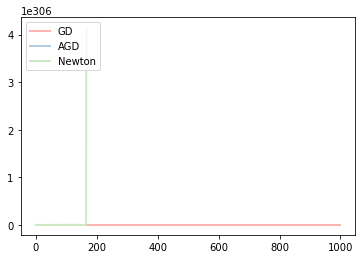

In [52]:
df = pd.DataFrame({'Iteration': [i for i in range(T)], 'GD': f1, 'AGD': f2, 'Newton': f3})
compare_algorithm(df)